# FWI Example with wavefield separation
This notebook explores performing up/down wavefield separation on source and receiver wavefields prior to correlation for a transmission experiment. We use a simple Kz wavenumber filter, zeroing negative or positive spatial frequencies in depth `z`. We then correlate source up with receiver up, and source down with receiver down.

We will contrast the wavefield separation FWI operator with the standard FWI operator. 

We will peform FWI using the following steps:
1. Prepare models
2. Build a small local compute cluster (2 workers) 
3. Create list of shot locations 
4. Build `F`, the distributed block operator for seismic modeling
5. Use `F` to create data for both models
6. Visualize data
7. Assess if data is cycle skipped at the farthest offsets
8. Build the `gradient!` and `cost` functions
9. Perform the FWI using `Optim.jl`
10. Visualize velocity models and objection function
11. Visualize data match 
12. Write models to local disk
13. Remove local files and workers

#### Note on runtime
Warning: this notebook takes more than 1 hour to run for 12 shots with two workers on an Intel 8168.

`lscpu` CPU information: `Intel(R) Xeon(R) Platinum 8168 CPU @ 2.70GHz`

## Add required packages
Uncomment the line below if you need to add these packages to your environment

In [1]:
# ]add Optim LineSearches

## Record time for start of notebook

In [2]:
time_beg = time()

1.603755929199503e9

In [3]:
using PyPlot, Distributed, Jets, JetPack, JetPackDSP, Printf

## 1. Prepare models
* Initial model is a wholespace
* True model is the initial model with a rectangular inclusion

In [4]:
dz,dx = 25,25
nz,nx = 251,251

v1 = 1500 .* ones(Float32,nz,nx);
v2 = 1500 .* ones(Float32,nz,nx);

w = 20
v1[div(nz,2)-w:div(nz,2)+w,div(nx,2)-w:div(nx,2)+w] .+= 200;

#### Visualize

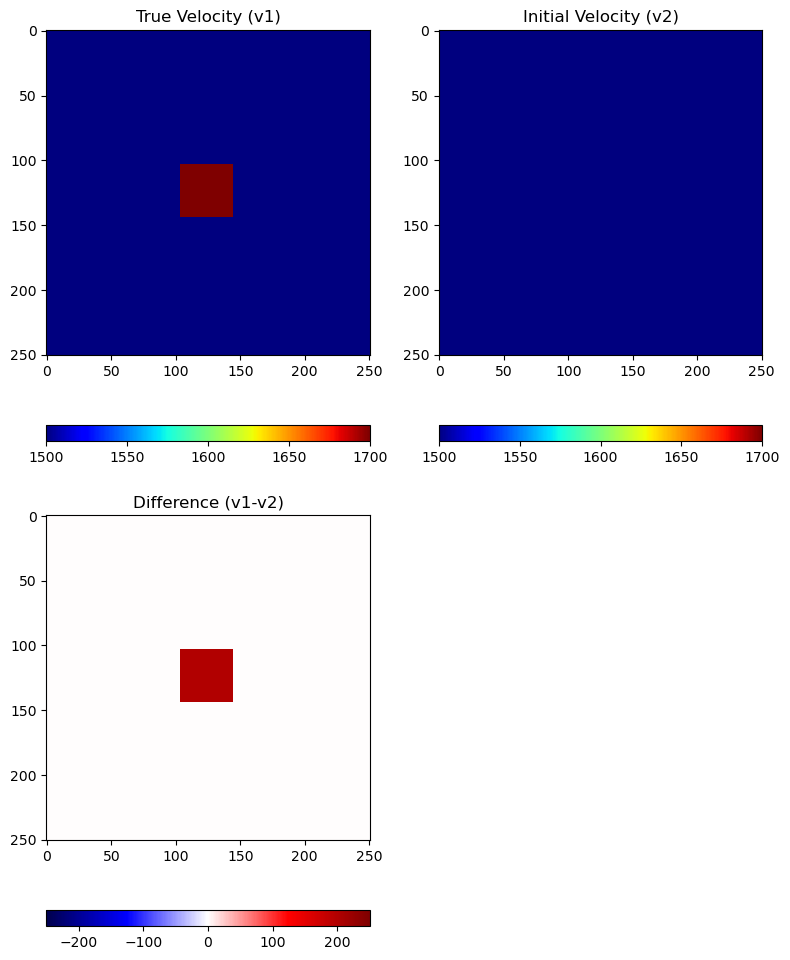

In [5]:
figure(figsize=(8,10))
vmin,vmax = extrema(v1)
dmin,dmax = -250,250

subplot(2,2,1); imshow(v1,aspect="auto",cmap="jet", interpolation="nearest"); 
colorbar(orientation="horizontal"); clim(vmin,vmax); title("True Velocity (v1)")

subplot(2,2,2); imshow(v2,aspect="auto",cmap="jet", interpolation="nearest");
colorbar(orientation="horizontal"); clim(vmin,vmax); title("Initial Velocity (v2)");

subplot(2,2,3); imshow(v1.-v2,aspect="auto",cmap="seismic", interpolation="nearest");
colorbar(orientation="horizontal"); clim(dmin,dmax); title("Difference (v1-v2)");

tight_layout()

## 2. Build a small local compute cluster (2 workers) 

#### Setup OMP environment variables for the cluster

In the distributed compute case the workers that we add would be on different hardware, and we might add tens of workers in 2D and hundreds in 3D. Here we run on a single machine with only 2 workers, and so we need to be careful with details related to high performance computing. If we did not specify thread affinity, the two workers would compete for the same physical cores and the modeling would be *incredibly* slow.

We spin up the small 2-worker cluster by calling `addprocs(2)`, and because we set the environment variable `ENV["OMP_DISPLAY_ENV"] = "true"` we will see the OMP environment printed out on each worker. In that output (below) we can verify that half of the total threads (44/2 = 22) are assigned to each socket on this 2 socket system. You can obtain more details about the hardware with the shell command `lscpu`.

We set four environment variables related to OpenMP:
* `OMP_DISPLAY_ENV` prints out the OpenMP environment on each worker
* `OMP_PROC_BIND` specifies that threads should be bound to physical cores
* `OMP_NUM_THREADS` specifies the number of threads per workers is 1/2 the number of physical cores
* `GOMP_CPU_AFFINITY` specifies which physical cores the threads run on for each worker

If you run the shell command `top` during execution, you will see 3 julia processes: the main process and two workers. The two workers should generally have about 50% of the system, and `load average` should tend towards the physical number of cores.

In [6]:
nthread = Sys.CPU_THREADS
ENV["OMP_DISPLAY_ENV"] = "true"
ENV["OMP_PROC_BIND"] = "close"
ENV["OMP_NUM_THREADS"] = "$(div(nthread,2))" 
addprocs(2)
@show workers()
for k in 1:nworkers()
    place1 = (k - 1) * div(nthread,nworkers())
    place2 = (k + 0) * div(nthread,nworkers()) - 1
    @show place1, place2, nthread
    @spawnat workers()[k] ENV["GOMP_CPU_AFFINITY"] = "$(place1)-$(place2)";
end

workers() = [2, 3]
(place1, place2, nthread) = (0, 21, 44)
(place1, place2, nthread) = (22, 43, 44)


In [7]:
@everywhere using Distributed, DistributedArrays, DistributedJets, Jets, JetPack, WaveFD, JetPackWaveFD, LinearAlgebra, LineSearches, Optim, Random

      From worker 2:	
      From worker 2:	OPENMP DISPLAY ENVIRONMENT BEGIN
      From worker 2:	  _OPENMP = '201511'
      From worker 2:	  OMP_DYNAMIC = 'FALSE'
      From worker 2:	  OMP_NESTED = 'FALSE'
      From worker 2:	  OMP_NUM_THREADS = '22'
      From worker 2:	  OMP_SCHEDULE = 'DYNAMIC'
      From worker 2:	  OMP_PROC_BIND = 'CLOSE'
      From worker 2:	  OMP_PLACES = '{0},{1},{2},{3},{4},{5},{6},{7},{8},{9},{10},{11},{12},{13},{14},{15},{16},{17},{18},{19},{20},{21}'
      From worker 2:	  OMP_STACKSIZE = '0'
      From worker 2:	  OMP_WAIT_POLICY = 'PASSIVE'
      From worker 2:	  OMP_THREAD_LIMIT = '4294967295'
      From worker 2:	  OMP_MAX_ACTIVE_LEVELS = '2147483647'
      From worker 2:	  OMP_CANCELLATION = 'FALSE'
      From worker 2:	  OMP_DEFAULT_DEVICE = '0'
      From worker 2:	  OMP_MAX_TASK_PRIORITY = '0'
      From worker 2:	  OMP_DISPLAY_AFFINITY = 'FALSE'
      From worker 2:	  OMP_AFFINITY_FORMAT = 'level %L thread %i affinity %A'
      From worker 2:	OPE

## 3. Create list of shot locations 
We use 12 shot locations evenly in depth along the left edge of the model.

In [8]:
nshots = 12
sz = round.(Int,collect(range(0,stop=(nz-1)*dz,length=nshots)))
@show nshots;
@show sz;

nshots = 12
sz = [0, 568, 1136, 1705, 2273, 2841, 3409, 3977, 4545, 5114, 5682, 6250]


## 4. Build `F1` and `F2`, the distributed block operators for seismic modeling
* `F1` is the standard operator
* `F2` is the operator with wavefield separation via Kz wavenumber filter

#### Note on scratch space for temporary files
When dealing with serialized nonlinear wavefields as in this example, we need to specify the location where scratch files will be written.

You may need to change this to point to a temporary directory available on your system.

In [9]:
@everywhere scratch = "/mnt/scratch"
@assert isdir(scratch)

In [10]:
@everywhere begin
    ntrec = 2001
    dtrec = 0.004
    dtmod = 0.002
end

@everywhere function makeF(i,nz,nx,dz,dx,sz; imgcondition="standard")
    @show imgcondition
    JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = div(Sys.CPU_THREADS,2),
        ntrec = ntrec,
        dtrec = dtrec,
        dtmod = dtmod,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=4.0),
        sz = sz[i],
        sx = dx,
        rz = dz * [0:1:nz-1;],
        rx = dx * (nx - 1) .* ones(nz),
        nbz_cache = nz,
        nbx_cache = 16,
        comptype = UInt32,
        nsponge = 100,
        imgcondition = imgcondition,
        srcfieldfile = joinpath(scratch, "field-$i-$(randstring()).bin"),
        reportinterval=0)
end

In [11]:
F1 = @blockop DArray(I->[makeF(i,nz,nx,dz,dx,sz,imgcondition="standard") 
        for i in I[1], j in I[2]], (nshots,1))

F2 = @blockop DArray(I->[makeF(i,nz,nx,dz,dx,sz,imgcondition="FWI") 
        for i in I[1], j in I[2]], (nshots,1))

      From worker 2:	imgcondition = "standard"
      From worker 3:	imgcondition = "standard"
      From worker 2:	imgcondition = "standard"
      From worker 2:	imgcondition = "standard"
      From worker 2:	imgcondition = "standard"
      From worker 2:	imgcondition = "standard"
      From worker 2:	imgcondition = "standard"
      From worker 3:	imgcondition = "standard"
      From worker 3:	imgcondition = "standard"
      From worker 3:	imgcondition = "standard"
      From worker 3:	imgcondition = "standard"
      From worker 3:	imgcondition = "standard"
      From worker 3:	imgcondition = "FWI"
      From worker 2:	imgcondition = "FWI"
      From worker 3:	imgcondition = "FWI"
      From worker 3:	imgcondition = "FWI"
      From worker 2:	imgcondition = "FWI"
      From worker 3:	imgcondition = "FWI"
      From worker 2:	imgcondition = "FWI"
      From worker 3:	imgcondition = "FWI"
      From worker 2:	imgcondition = "FWI"
      From worker 3:	imgcondition = "FWI"
      From worke

"Jet nonlinear operator, (251, 251) → (6027012,)"

## 5. Use `F1` to create the data in both models

In [12]:
t1 = @elapsed begin
    d1 = F1*v1;
end
@info @sprintf("Time in true model; %.2f seconds\n", t1);

t2 = @elapsed begin
    d2 = F1*v2;
end
@info @sprintf("Time in init model; %.2f seconds\n", t2);

┌ Info: Time in true model; 28.36 seconds
└ @ Main In[12]:4
┌ Info: Time in init model; 19.78 seconds
└ @ Main In[12]:9


#### Compute the residual data

In [13]:
r = d1 .- d2;

## 6. Visualize data

#### Collect 3 shots locally before plotting

In [14]:
shots = [1,6,12]
szlocal = [sz[i] for i in shots]
@show shots
@show szlocal;

d1local = [getblock(d1,i) for i in shots];
d2local = [getblock(d2,i) for i in shots];
rlocal = [getblock(r,i) for i in shots];

shots = [1, 6, 12]
szlocal = [0, 2841, 6250]


#### Plot shot gathers for true model, initial model, and residual

The table below describes the data images below.

<table style="border:1px solid black;" width="60%">
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial Residual Data</b></td>
</tr>
</table>

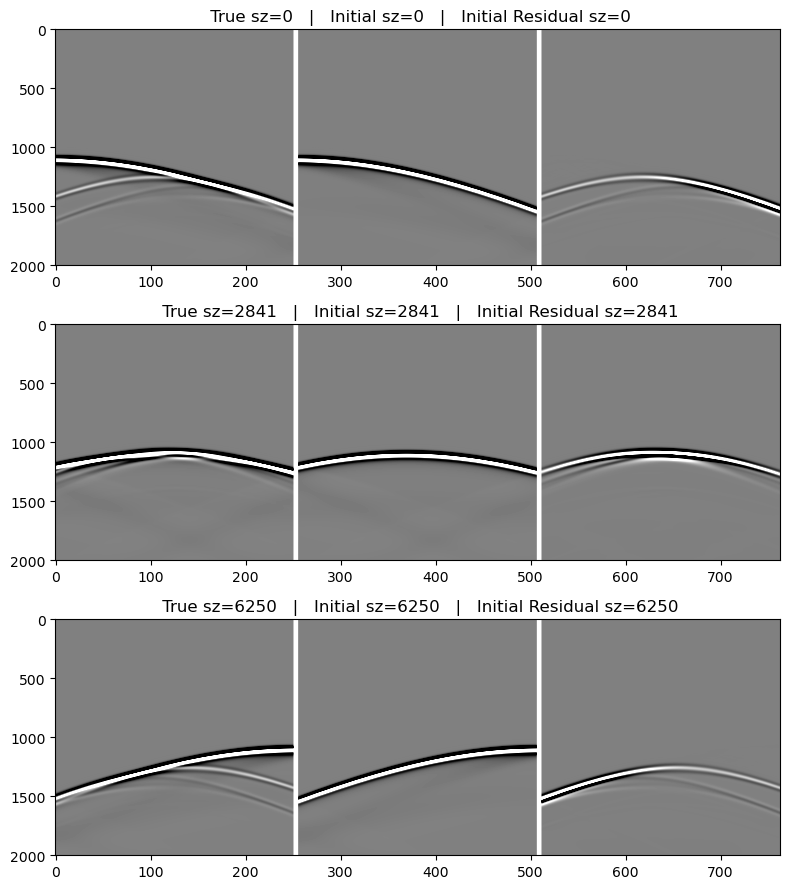

scale = 17.554220204326107


In [15]:
scale = 10.0 / sqrt(norm(d1)^2 / length(d1))
@show scale

nzero = 5
pad = ones(Float32,ntrec,nzero)

figure(figsize=(8,9)); clf()
for (iplot,ishot) in enumerate(shots)
    cat2 = hcat(d1local[iplot], pad, d2local[iplot], pad, rlocal[iplot])
    subplot(3,1,iplot);
    imshow(cat2,cmap="gray",aspect="auto",clim=[-1,+1]);
    title(" True sz=$(sz[ishot])   |   Initial sz=$(sz[ishot])   |   Initial Residual sz=$(sz[ishot])");
end
tight_layout()

## 8. Build the `gradient!` and `cost` functions

#### Build the `gradient!` function
This method is called by the solver whenever the gradient is required. Note one difference for this transmission experiment relative the first FWI notebook is that we do not want to apply source side illumination compensation.

Steps in computing the gradient are as follows:
1. Apply box constraints to keep velocity inside `[vmin,vmax]`
1. Apply the adjoint of the Jacobian to the current residual `J' * [F*v - d]` 
1. Apply simple scaling based on the size of the first gradient, and save to apply to future gradients

We can use this function for both operators `F1` and `F2`, but we need to be careful about the `FwiPar` struct we use to save the maximum value of the first gradient. 

In [16]:
function gradient!(G,F,v,dobs,p)
    clamp!(v,vmin,vmax)
    J = jacobian(F,v)
    t = @elapsed begin
        dv = F*v
        G .= J' * (dv .- dobs)
    end
    ϕ = 0.5 * norm(dv .- dobs)^2
    p.countG += 1
    @printf("f=%3d g=%3d %10.4f sec -- |Fv-y| %10.4e -- |g| %10.4e\n", 
        p.countF, p.countG, t, ϕ, norm(G))
    flush(stdout)
    if p.gscale == 0.0
        # compute scalar from first gradient, apply to future gradients
        p.gscale = 10 ./ maximum(G) 
    end
    G .*= p.gscale
end
# struct to save the first gradient scalar
mutable struct FwiPar
   countF::Int64
   countG::Int64
   gscale::Float64
end

#### Compute gradients with and without wavefield separation and display

In [17]:
grad1 = zeros(Float32,size(v1))
grad2 = zeros(Float32,size(v1))

tgrad1 = @elapsed begin
    p1 = FwiPar(0,0,0.0)
    gradient!(grad1,F1,v2,d1,p1)
end
@show tgrad1;

tgrad2 = @elapsed begin
    p2 = FwiPar(0,0,0.0)
    gradient!(grad2,F2,v2,d1,p2)
end
@show tgrad2;

f=  0 g=  1    14.8362 sec -- |Fv-y| 5.8364e+05 -- |g| 9.5099e+01
tgrad1 = 15.852845676
f=  0 g=  1    65.4716 sec -- |Fv-y| 5.8382e+05 -- |g| 4.3223e+01
tgrad2 = 65.774722322


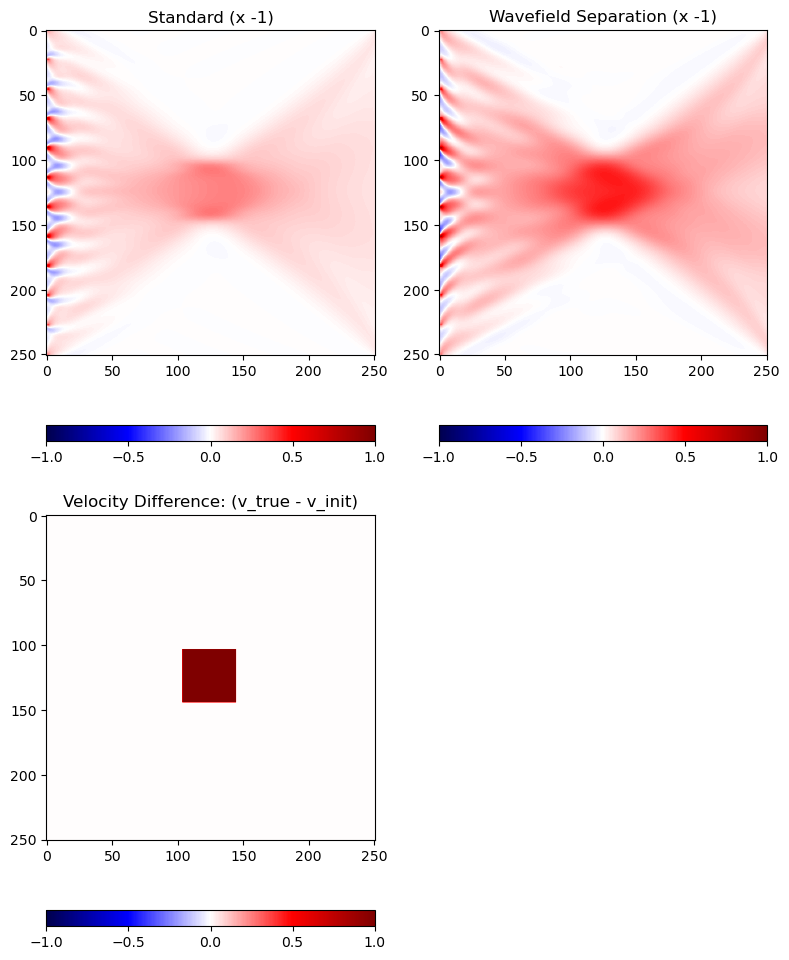

In [18]:
dv = v1 .- v2

figure(figsize=(8,10))

subplot(2,2,1)
imshow(-1 .* grad1 ./ maximum(abs,grad1),aspect="auto",cmap="seismic");
colorbar(orientation="horizontal");clim(-1,1);
title("Standard (x -1)");

subplot(2,2,2)
imshow(-1 .* grad2 ./ maximum(abs,grad2),aspect="auto",cmap="seismic");
colorbar(orientation="horizontal");clim(-1,1);
title("Wavefield Separation (x -1)");

subplot(2,2,3)
imshow(dv ./ maximum(abs,dv),aspect="auto",cmap="seismic");
colorbar(orientation="horizontal");clim(-1,1);
title("Velocity Difference: (v_true - v_init)");

tight_layout()

#### Build the `cost` function
Note we also need to apply box constraints here to keep the model in the range `[vmin,vmax]`.

In [19]:
function cost(x,F,d1,p)
    clamp!(x,vmin,vmax)
    t = @elapsed begin
        dx = F*x
    end
    ϕ = 0.5 * norm(d1 .- dx)^2
    p.countF += 1
    @printf("f=%3d g=%3d %10.4f sec -- |Fv-y| %10.4e\n", p.countF, p.countG, t, ϕ)
    flush(stdout)
    return ϕ
end

cost (generic function with 1 method)

In [20]:
p1 = FwiPar(0,0,0.0)
@show cost(v2,F1,d1,p1)
p2 = FwiPar(0,0,0.0)
@show cost(v2,F2,d1,p2)

f=  1 g=  0     0.6151 sec -- |Fv-y| 5.8364e+05
cost(v2, F1, d1, p1) = 583636.3125
f=  1 g=  0     0.6917 sec -- |Fv-y| 5.8364e+05
cost(v2, F2, d1, p2) = 583636.3125


583636.3125

## 9. Perform the FWI using `Optim.jl`
We will do 10 iterations of limited memory BFGS for each operator. 

In [21]:
niter = 10

20

In [22]:
function mycallback(state::OptimizationState)
    @info "iter=$(state.iteration), cost=$(state.value), |grad|=$(state.g_norm)"
    flush(stdout)
    false
end
mycallback(trace::OptimizationTrace) = mycallback(trace[end]);

#### Optimization with the standard operator

In [23]:
topt1 = @elapsed begin
    p1 = FwiPar(0,0,0.0)
    f(x) = cost(x,F1,d1,p1)
    g!(G,x) = gradient!(G,F1,x,d1,p1)

    solver1 = LBFGS(m = niter, 
        alphaguess = LineSearches.InitialPrevious(), 
        linesearch = LineSearches.BackTracking(order=2));

    result1 = optimize(f, g!, v2, solver1,
        Optim.Options(
            iterations = niter,
            show_trace = false,
            store_trace = true,
            show_every = 1,
            extended_trace = true,
            allow_f_increases = false,
            callback = mycallback))
end;

f=  0 g=  1    10.6357 sec -- |Fv-y| 5.8364e+05 -- |g| 9.5099e+01
f=  1 g=  1     0.6187 sec -- |Fv-y| 5.8364e+05


┌ Info: iter=0, cost=583636.3, |grad|=94.34326
└ @ Main In[22]:2


f=  2 g=  1    25.8295 sec -- |Fv-y| 3.1178e+05
f=  2 g=  2    10.7561 sec -- |Fv-y| 3.1165e+05 -- |g| 7.8286e+01


┌ Info: iter=1, cost=311784.97, |grad|=29.322193
└ @ Main In[22]:2


f=  3 g=  2    25.7067 sec -- |Fv-y| 5.0333e+05
f=  4 g=  2    26.5832 sec -- |Fv-y| 2.2435e+05
f=  4 g=  3    38.2368 sec -- |Fv-y| 2.2435e+05 -- |g| 9.7930e+01
f=  5 g=  3     0.6718 sec -- |Fv-y| 2.2424e+05


┌ Info: iter=2, cost=224243.9, |grad|=46.35753
└ @ Main In[22]:2


f=  6 g=  3    27.9855 sec -- |Fv-y| 1.7171e+05
f=  6 g=  4    12.7290 sec -- |Fv-y| 1.7165e+05 -- |g| 8.7954e+01


┌ Info: iter=3, cost=171711.88, |grad|=45.288513
└ @ Main In[22]:2


f=  7 g=  4    29.0920 sec -- |Fv-y| 6.9312e+04
f=  7 g=  5    13.1125 sec -- |Fv-y| 6.9300e+04 -- |g| 6.7561e+01


┌ Info: iter=4, cost=69311.96, |grad|=27.541393
└ @ Main In[22]:2


f=  8 g=  5    29.1655 sec -- |Fv-y| 1.3007e+05
f=  9 g=  5    29.7456 sec -- |Fv-y| 8.6245e+04
f= 10 g=  5    29.7703 sec -- |Fv-y| 7.0628e+04
f= 11 g=  5    29.8701 sec -- |Fv-y| 6.7401e+04
f= 11 g=  6    43.1574 sec -- |Fv-y| 6.7401e+04 -- |g| 6.6384e+01
f= 12 g=  6     0.6813 sec -- |Fv-y| 6.7382e+04


┌ Info: iter=5, cost=67382.04, |grad|=28.73596
└ @ Main In[22]:2


f= 13 g=  6    30.3399 sec -- |Fv-y| 1.5110e+05
f= 14 g=  6    30.5404 sec -- |Fv-y| 1.2204e+05
f= 15 g=  6    30.4108 sec -- |Fv-y| 9.0763e+04
f= 16 g=  6    30.3945 sec -- |Fv-y| 7.2941e+04
f= 17 g=  6    30.6124 sec -- |Fv-y| 6.7656e+04
f= 18 g=  6    30.8025 sec -- |Fv-y| 6.6686e+04
f= 18 g=  7    44.0085 sec -- |Fv-y| 6.6686e+04 -- |g| 6.5477e+01
f= 19 g=  7     0.6847 sec -- |Fv-y| 6.6667e+04


┌ Info: iter=6, cost=66667.28, |grad|=28.215414
└ @ Main In[22]:2


f= 20 g=  7    31.1505 sec -- |Fv-y| 1.9011e+05
f= 21 g=  7    31.4758 sec -- |Fv-y| 1.3781e+05
f= 22 g=  7    31.5096 sec -- |Fv-y| 1.0230e+05
f= 23 g=  7    31.8590 sec -- |Fv-y| 7.7599e+04
f= 24 g=  7    31.4971 sec -- |Fv-y| 6.9103e+04
f= 25 g=  7    31.4789 sec -- |Fv-y| 6.6678e+04
f= 26 g=  7    31.1041 sec -- |Fv-y| 6.6299e+04
f= 26 g=  8    44.6672 sec -- |Fv-y| 6.6299e+04 -- |g| 6.5135e+01
f= 27 g=  8     0.6726 sec -- |Fv-y| 6.6278e+04


┌ Info: iter=7, cost=66278.42, |grad|=28.458755
└ @ Main In[22]:2


f= 28 g=  8    31.2991 sec -- |Fv-y| 2.2825e+05
f= 29 g=  8    31.7075 sec -- |Fv-y| 1.6676e+05
f= 30 g=  8    31.1763 sec -- |Fv-y| 1.2757e+05
f= 31 g=  8    31.3313 sec -- |Fv-y| 9.9133e+04
f= 32 g=  8    31.4032 sec -- |Fv-y| 7.7063e+04
f= 33 g=  8    31.3780 sec -- |Fv-y| 6.8608e+04
f= 34 g=  8    32.2119 sec -- |Fv-y| 6.6275e+04
f= 35 g=  8    31.9882 sec -- |Fv-y| 6.5853e+04
f= 35 g=  9    45.7440 sec -- |Fv-y| 6.5853e+04 -- |g| 6.4548e+01
f= 36 g=  9     0.6786 sec -- |Fv-y| 6.5832e+04


┌ Info: iter=8, cost=65832.125, |grad|=28.368628
└ @ Main In[22]:2


f= 37 g=  9    31.8261 sec -- |Fv-y| 2.3555e+05
f= 38 g=  9    31.8178 sec -- |Fv-y| 1.6217e+05
f= 39 g=  9    32.0327 sec -- |Fv-y| 1.2057e+05
f= 40 g=  9    32.0238 sec -- |Fv-y| 9.4308e+04
f= 41 g=  9    32.1216 sec -- |Fv-y| 7.5130e+04
f= 42 g=  9    32.1444 sec -- |Fv-y| 6.8263e+04
f= 43 g=  9    32.1537 sec -- |Fv-y| 6.6239e+04
f= 44 g=  9    32.2899 sec -- |Fv-y| 6.5782e+04
f= 45 g=  9    32.2698 sec -- |Fv-y| 6.5737e+04
f= 45 g= 10    45.7761 sec -- |Fv-y| 6.5736e+04 -- |g| 6.4324e+01
f= 46 g= 10     0.6691 sec -- |Fv-y| 6.5716e+04


┌ Info: iter=9, cost=65716.336, |grad|=28.41282
└ @ Main In[22]:2


f= 47 g= 10    31.8804 sec -- |Fv-y| 2.8483e+05
f= 48 g= 10    32.0553 sec -- |Fv-y| 1.8563e+05
f= 49 g= 10    32.0442 sec -- |Fv-y| 1.3179e+05
f= 50 g= 10    32.7223 sec -- |Fv-y| 1.0078e+05
f= 51 g= 10    31.9143 sec -- |Fv-y| 7.9715e+04
f= 52 g= 10    32.5424 sec -- |Fv-y| 7.0184e+04
f= 53 g= 10    33.3277 sec -- |Fv-y| 6.7055e+04
f= 54 g= 10    32.1331 sec -- |Fv-y| 6.6058e+04
f= 55 g= 10    32.0981 sec -- |Fv-y| 6.5799e+04
f= 56 g= 10    32.1603 sec -- |Fv-y| 6.5742e+04
f= 57 g= 10    32.4413 sec -- |Fv-y| 6.5732e+04
f= 58 g= 10    31.9678 sec -- |Fv-y| 6.5733e+04
f= 59 g= 10    32.1656 sec -- |Fv-y| 6.5734e+04
f= 60 g= 10    32.5227 sec -- |Fv-y| 6.5735e+04
f= 61 g= 10    32.0509 sec -- |Fv-y| 6.5736e+04
f= 62 g= 10    32.4918 sec -- |Fv-y| 6.5736e+04
f= 63 g= 10    32.1496 sec -- |Fv-y| 6.5736e+04
f= 64 g= 10    32.5271 sec -- |Fv-y| 6.5736e+04
f= 65 g= 10    32.2549 sec -- |Fv-y| 6.5736e+04
f= 66 g= 10    32.1189 sec -- |Fv-y| 6.5736e+04
f= 67 g= 10    32.1637 sec -- |Fv-y| 6.5

In [24]:
@info @printf("Time for optimization (standard); %.2f minutes\n", topt1 / 60)
@info "result1=\n$result1\n"

Time for optimization (standard); 38.17 minutes


┌ Info: nothing
└ @ Main In[24]:1
┌ Info: result1=
│  * Status: failure (line search failed)
│ 
│  * Candidate solution
│     Final objective value:     6.573646e+04
│ 
│  * Found with
│     Algorithm:     L-BFGS
│ 
│  * Convergence measures
│     |x - x'|               = 0.00e+00 ≤ 0.0e+00
│     |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
│     |f(x) - f(x')|         = 2.01e+01 ≰ 0.0e+00
│     |f(x) - f(x')|/|f(x')| = 3.06e-04 ≰ 0.0e+00
│     |g(x)|                 = 2.84e+01 ≰ 1.0e-08
│ 
│  * Work counters
│     Seconds run:   1502  (vs limit Inf)
│     Iterations:    10
│     f(x) calls:    70
│     ∇f(x) calls:   10
│ 
└ @ Main In[24]:2


#### Optimization with the wavefield separation operator

In [25]:
topt2 = @elapsed begin
    p2 = FwiPar(0,0,0.0)
    f(x) = cost(x,F1,d1,p2)
    g!(G,x) = gradient!(G,F1,x,d1,p2)

    solver2 = LBFGS(m = niter, 
        alphaguess = LineSearches.InitialPrevious(), 
        linesearch = LineSearches.BackTracking(order=2));

    result2 = optimize(f, g!, v2, solver2,
        Optim.Options(
            iterations = niter,
            show_trace = false,
            store_trace = true,
            show_every = 1,
            extended_trace = true,
            allow_f_increases = false,
            callback = mycallback))
end;

f=  0 g=  1    45.7949 sec -- |Fv-y| 5.8382e+05 -- |g| 9.5093e+01
f=  1 g=  1     0.6162 sec -- |Fv-y| 5.8364e+05


┌ Info: iter=0, cost=583636.3, |grad|=94.307846
└ @ Main In[22]:2


f=  2 g=  1    32.0474 sec -- |Fv-y| 3.1196e+05
f=  2 g=  2    14.5442 sec -- |Fv-y| 3.1183e+05 -- |g| 7.8286e+01


┌ Info: iter=1, cost=311958.34, |grad|=29.29828
└ @ Main In[22]:2


f=  3 g=  2    31.7261 sec -- |Fv-y| 5.0468e+05
f=  4 g=  2    31.8761 sec -- |Fv-y| 2.2444e+05
f=  4 g=  3    45.5273 sec -- |Fv-y| 2.2444e+05 -- |g| 9.7987e+01
f=  5 g=  3     0.6579 sec -- |Fv-y| 2.2434e+05


┌ Info: iter=2, cost=224340.05, |grad|=46.346825
└ @ Main In[22]:2


f=  6 g=  3    31.6324 sec -- |Fv-y| 1.7171e+05
f=  6 g=  4    14.7596 sec -- |Fv-y| 1.7165e+05 -- |g| 8.7919e+01


┌ Info: iter=3, cost=171712.6, |grad|=45.2148
└ @ Main In[22]:2


f=  7 g=  4    31.7737 sec -- |Fv-y| 6.8724e+04
f=  7 g=  5    14.5566 sec -- |Fv-y| 6.8713e+04 -- |g| 6.7279e+01


┌ Info: iter=4, cost=68724.43, |grad|=27.348248
└ @ Main In[22]:2


f=  8 g=  5    31.9336 sec -- |Fv-y| 1.2811e+05
f=  9 g=  5    32.2377 sec -- |Fv-y| 8.4775e+04
f= 10 g=  5    31.8997 sec -- |Fv-y| 6.9609e+04
f= 11 g=  5    32.3256 sec -- |Fv-y| 6.6621e+04
f= 11 g=  6    45.5906 sec -- |Fv-y| 6.6621e+04 -- |g| 6.6052e+01
f= 12 g=  6     0.6776 sec -- |Fv-y| 6.6604e+04


┌ Info: iter=5, cost=66604.34, |grad|=28.52696
└ @ Main In[22]:2


f= 13 g=  6    32.1929 sec -- |Fv-y| 1.4829e+05
f= 14 g=  6    32.1319 sec -- |Fv-y| 1.1954e+05
f= 15 g=  6    32.0813 sec -- |Fv-y| 8.8380e+04
f= 16 g=  6    31.7587 sec -- |Fv-y| 7.1413e+04
f= 17 g=  6    32.3958 sec -- |Fv-y| 6.6541e+04
f= 18 g=  6    32.2050 sec -- |Fv-y| 6.5767e+04
f= 18 g=  7    46.2557 sec -- |Fv-y| 6.5767e+04 -- |g| 6.5115e+01
f= 19 g=  7     0.6797 sec -- |Fv-y| 6.5748e+04


┌ Info: iter=6, cost=65748.49, |grad|=27.985586
└ @ Main In[22]:2


f= 20 g=  7    32.2755 sec -- |Fv-y| 1.8602e+05
f= 21 g=  7    32.3292 sec -- |Fv-y| 1.3395e+05
f= 22 g=  7    32.3647 sec -- |Fv-y| 9.8640e+04
f= 23 g=  7    32.0883 sec -- |Fv-y| 7.5255e+04
f= 24 g=  7    32.3457 sec -- |Fv-y| 6.7531e+04
f= 25 g=  7    32.3292 sec -- |Fv-y| 6.5463e+04
f= 25 g=  8    46.4897 sec -- |Fv-y| 6.5463e+04 -- |g| 6.4723e+01
f= 26 g=  8     0.7091 sec -- |Fv-y| 6.5443e+04


┌ Info: iter=7, cost=65442.97, |grad|=28.669777
└ @ Main In[22]:2


f= 27 g=  8    32.2986 sec -- |Fv-y| 2.3219e+05
f= 28 g=  8    32.6521 sec -- |Fv-y| 1.7107e+05
f= 29 g=  8    32.5111 sec -- |Fv-y| 1.3256e+05
f= 30 g=  8    32.5626 sec -- |Fv-y| 1.0420e+05
f= 31 g=  8    32.7456 sec -- |Fv-y| 8.1976e+04
f= 32 g=  8    32.3416 sec -- |Fv-y| 7.0297e+04
f= 33 g=  8    32.5652 sec -- |Fv-y| 6.6625e+04
f= 34 g=  8    32.2402 sec -- |Fv-y| 6.5621e+04
f= 35 g=  8    33.2591 sec -- |Fv-y| 6.5410e+04
f= 36 g=  8    32.1801 sec -- |Fv-y| 6.5388e+04
f= 36 g=  9    45.9996 sec -- |Fv-y| 6.5388e+04 -- |g| 6.4575e+01
f= 37 g=  9     0.6785 sec -- |Fv-y| 6.5368e+04


┌ Info: iter=8, cost=65368.08, |grad|=28.692072
└ @ Main In[22]:2


f= 38 g=  9    32.2199 sec -- |Fv-y| 2.6367e+05
f= 39 g=  9    32.4731 sec -- |Fv-y| 1.7811e+05
f= 40 g=  9    32.0728 sec -- |Fv-y| 1.2967e+05
f= 41 g=  9    32.3655 sec -- |Fv-y| 1.0012e+05
f= 42 g=  9    32.1661 sec -- |Fv-y| 7.8413e+04
f= 43 g=  9    32.1412 sec -- |Fv-y| 6.8978e+04
f= 44 g=  9    32.2564 sec -- |Fv-y| 6.6112e+04
f= 45 g=  9    31.8953 sec -- |Fv-y| 6.5382e+04
f= 46 g=  9    32.0255 sec -- |Fv-y| 6.5279e+04
f= 46 g= 10    46.2157 sec -- |Fv-y| 6.5279e+04 -- |g| 6.4313e+01
f= 47 g= 10     0.6608 sec -- |Fv-y| 6.5260e+04


┌ Info: iter=9, cost=65259.51, |grad|=28.711704
└ @ Main In[22]:2


f= 48 g= 10    32.3453 sec -- |Fv-y| 2.8515e+05
f= 49 g= 10    32.3547 sec -- |Fv-y| 1.8559e+05
f= 50 g= 10    32.2873 sec -- |Fv-y| 1.3122e+05
f= 51 g= 10    32.4436 sec -- |Fv-y| 9.9815e+04
f= 52 g= 10    32.1615 sec -- |Fv-y| 7.8867e+04
f= 53 g= 10    32.1822 sec -- |Fv-y| 6.9651e+04
f= 54 g= 10    32.0172 sec -- |Fv-y| 6.6620e+04
f= 55 g= 10    32.2535 sec -- |Fv-y| 6.5626e+04
f= 56 g= 10    32.3081 sec -- |Fv-y| 6.5353e+04
f= 57 g= 10    32.0308 sec -- |Fv-y| 6.5290e+04
f= 58 g= 10    32.0740 sec -- |Fv-y| 6.5278e+04
f= 59 g= 10    32.1375 sec -- |Fv-y| 6.5277e+04
f= 60 g= 10    32.1871 sec -- |Fv-y| 6.5278e+04
f= 61 g= 10    32.0984 sec -- |Fv-y| 6.5278e+04
f= 62 g= 10    32.3034 sec -- |Fv-y| 6.5278e+04
f= 63 g= 10    32.4913 sec -- |Fv-y| 6.5279e+04
f= 64 g= 10    31.9890 sec -- |Fv-y| 6.5279e+04
f= 65 g= 10    32.4162 sec -- |Fv-y| 6.5279e+04
f= 66 g= 10    32.2033 sec -- |Fv-y| 6.5279e+04
f= 67 g= 10    31.9024 sec -- |Fv-y| 6.5279e+04
f= 68 g= 10    32.3260 sec -- |Fv-y| 6.5

In [26]:
@info @printf("Time for optimization (wavefield separation); %.2f minutes\n", topt2 / 60)
@info "result2=\n$result2\n"

Time for optimization (wavefield separation); 40.57 minutes


┌ Info: nothing
└ @ Main In[26]:1
┌ Info: result2=
│  * Status: failure (line search failed)
│ 
│  * Candidate solution
│     Final objective value:     6.527863e+04
│ 
│  * Found with
│     Algorithm:     L-BFGS
│ 
│  * Convergence measures
│     |x - x'|               = 0.00e+00 ≤ 0.0e+00
│     |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
│     |f(x) - f(x')|         = 1.91e+01 ≰ 0.0e+00
│     |f(x) - f(x')|/|f(x')| = 2.93e-04 ≰ 0.0e+00
│     |g(x)|                 = 2.87e+01 ≰ 1.0e-08
│ 
│  * Work counters
│     Seconds run:   1614  (vs limit Inf)
│     Iterations:    10
│     f(x) calls:    71
│     ∇f(x) calls:   10
│ 
└ @ Main In[26]:2


In [27]:
vf1 = Optim.minimizer(result1);
vf2 = Optim.minimizer(result2);

clamp!(vf1,vmin,vmax);
clamp!(vf2,vmin,vmax);

ϕ1 = Optim.f_trace(result1);
ϕ2 = Optim.f_trace(result2);

m1 = Optim.x_trace(result1);
m2 = Optim.x_trace(result2);

## 10. Visualize velocity models and objective function

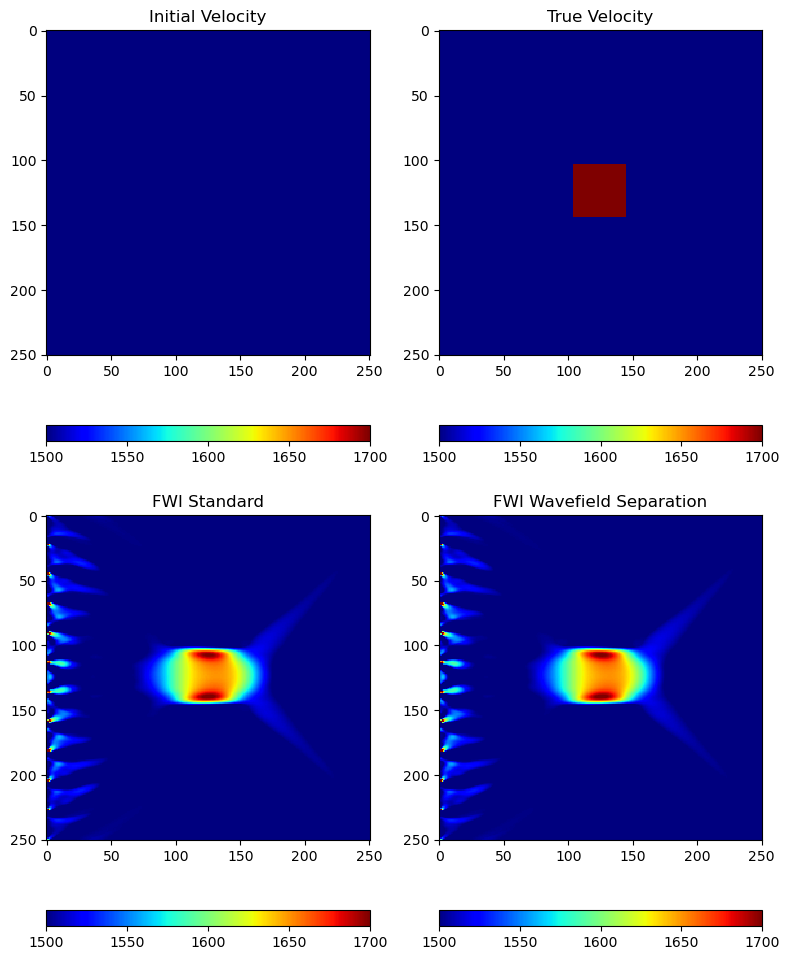

In [28]:
figure(figsize=(8,10)); clf()

subplot(2,2,1);imshow(v2,aspect="auto",cmap="jet", interpolation="nearest");
colorbar(orientation="horizontal"); clim(vmin,vmax);title("Initial Velocity");

subplot(2,2,2);imshow(v1,aspect="auto",cmap="jet", interpolation="nearest");
colorbar(orientation="horizontal"); clim(vmin,vmax);title("True Velocity")

subplot(2,2,3);imshow(vf1,aspect="auto",cmap="jet", interpolation="nearest");
colorbar(orientation="horizontal"); clim(vmin,vmax);title("FWI Standard");

subplot(2,2,4);imshow(vf2,aspect="auto",cmap="jet", interpolation="nearest");
colorbar(orientation="horizontal"); clim(vmin,vmax);title("FWI Wavefield Separation");

tight_layout()

#### Display the velocity differences 

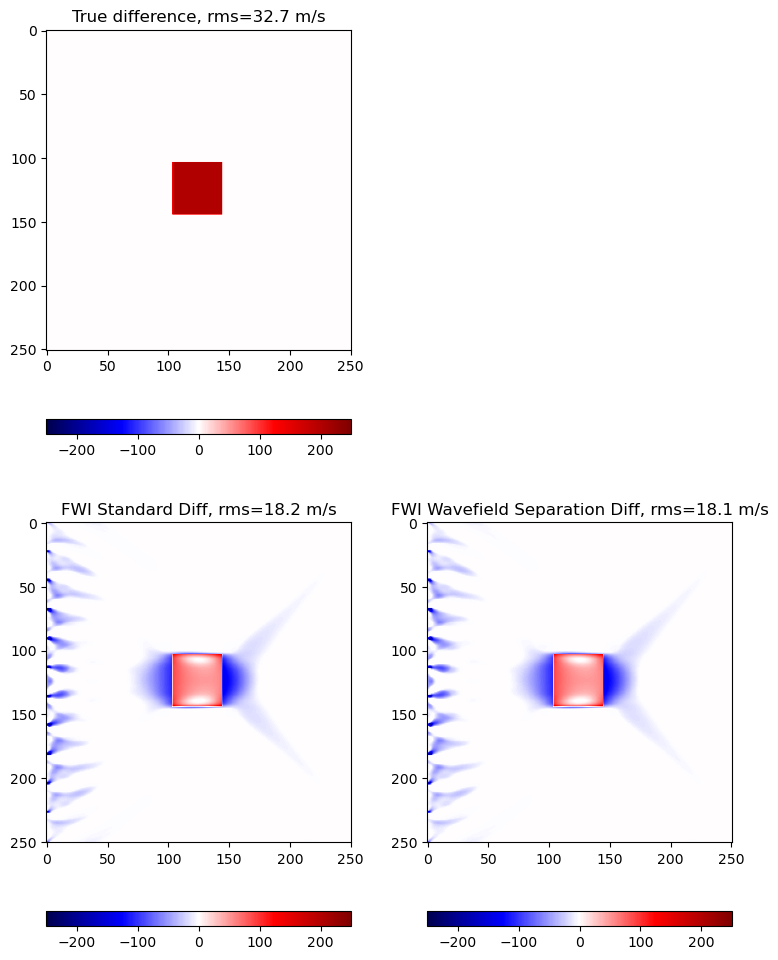

In [29]:
rms_v2  = @sprintf("%.1f m/s", sqrt(norm(v1 .- v2)^2 / length(v1)))
rms_vf1 = @sprintf("%.1f m/s", sqrt(norm(v1 .- vf1)^2 / length(v1)))
rms_vf2 = @sprintf("%.1f m/s", sqrt(norm(v1 .- vf2)^2 / length(v1)))

figure(figsize=(8,10)); clf()

subplot(2,2,1);imshow(v1 .- v2,aspect="auto",cmap="seismic");
colorbar(orientation="horizontal");clim(dmin,dmax);
title("True difference, rms=$(rms_v2)");

subplot(2,2,3);imshow(v1 .- vf1,aspect="auto",cmap="seismic");
colorbar(orientation="horizontal");clim(dmin,dmax);
title("FWI Standard Diff, rms=$(rms_vf1)");

subplot(2,2,4);imshow(v1 .- vf2,aspect="auto",cmap="seismic");
colorbar(orientation="horizontal");clim(dmin,dmax);
title("FWI Wavefield Separation Diff, rms=$(rms_vf2)");

tight_layout()

#### Display the cost function 

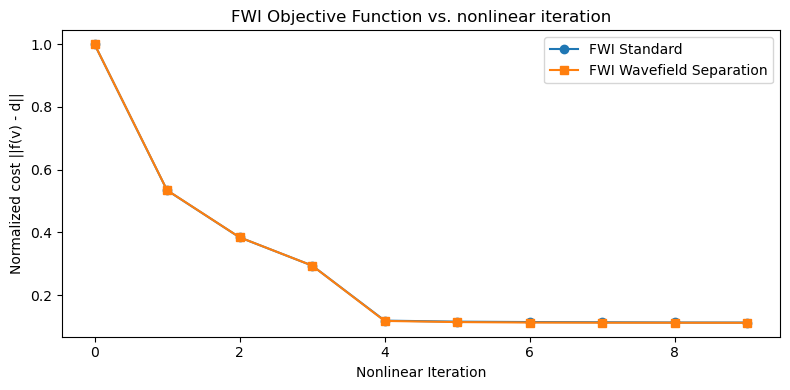

ϕ1[end] / ϕ1[1] = 0.11259809f0
ϕ2[end] / ϕ2[1] = 0.11181537f0
length(iters1) = 10


10

In [30]:
figure(figsize=(8,4)); clf()
iters1 = [0:length(ϕ1)-1;]
iters2 = [0:length(ϕ2)-1;]
plot(iters1, ϕ1 ./ ϕ1[1], marker="o", label="FWI Standard")
plot(iters2, ϕ2 ./ ϕ2[1], marker="s", label="FWI Wavefield Separation")
legend()
xlabel("Nonlinear Iteration")
ylabel("Normalized cost ||f(v) - d||")
title("FWI Objective Function vs. nonlinear iteration");
tight_layout()

@show ϕ1[end] / ϕ1[1]
@show ϕ2[end] / ϕ2[1]

@show length(iters1)

#### Display data misfit vs model misfit

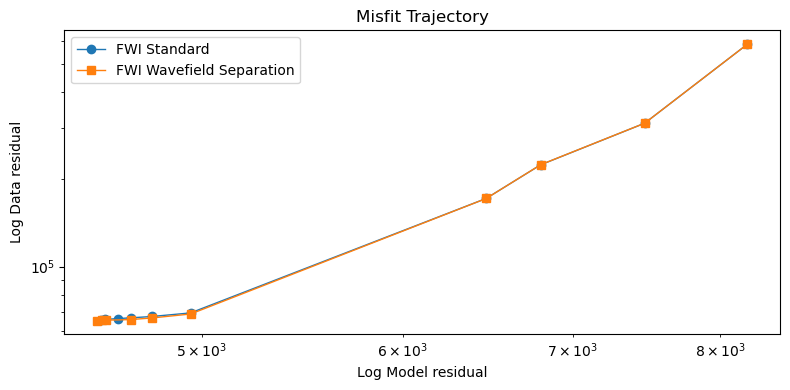

In [31]:
figure(figsize=(8,4)); clf()

c1 = [norm(m1[i] .- v1) for i in 1:length(m1)]
c2 = [norm(m2[i] .- v1) for i in 1:length(m2)]

loglog(c1, ϕ1, label="FWI Standard", marker="o", linewidth=1)
loglog(c2, ϕ2, label="FWI Wavefield Separation", marker="s", linewidth=1)
legend()
xlabel("Log Model residual")
ylabel("Log Data residual")
title("Misfit Trajectory");
tight_layout()

## 11. Visualize data match
#### Generate data in the FWI velocity models

In [32]:
tf1 = @elapsed begin
    df1 = F1*vf1;
end
@show tf1;

tf2 = @elapsed begin
    df2 = F1*vf2;
end
@show tf2;

tf1 = 32.187789069
tf2 = 31.8091281


#### Compute residuals and collect gathers for display

In [33]:
rf1 = d1 .- df1;
rf2 = d1 .- df2;

df1local = [getblock(df1,i) for i in shots];
df2local = [getblock(df2,i) for i in shots];
rf1local = [getblock(rf1,i) for i in shots];
rf2local = [getblock(rf2,i) for i in shots];

#### Plot shot gathers for true, initial model, and fwi models

The table below describes the data images below. We include the initial data as shown above for easier comparison. 

<table style="border:1px solid black;" width="60%">
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial Residual</b></td>
</tr>
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI Standard</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI Standard Residual</b></td>
</tr>
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI Wavefield Separation</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI Wavefield Separation Residual</b></td>
</tr>
</table>

We first make a function to create the plots that we can re-use for the selected shots.

In [34]:
function make_plot(index)
    figure(figsize=(8,9)); clf()
    catii = hcat(d1local[index],  pad, d2local[index],  pad, r2local[index])
    catf1 = hcat(df1local[index], pad, df1local[index], pad, rf1local[index])
    catf2 = hcat(df2local[index], pad, df2local[index], pad, rf2local[index])

    subplot(3,1,1);
    imshow(catii,cmap="gray",aspect="auto",clim=[-1,+1]);
    title("True sx=$(sx[index])   |   Initial sx=$(sx[index])   |   Initial Residual sx=$(sx[index])");
    
    subplot(3,1,2);
    imshow(catf1,cmap="gray",aspect="auto",clim=[-1,+1]);
    title("True sx=$(sx[index])   |   FWI Standard sx=$(sx[index])   |   Initial Residual sx=$(sx[index])");
    
    subplot(3,1,3);
    imshow(catf2,cmap="gray",aspect="auto",clim=[-1,+1]);
    title("True sx=$(sx[index])   |   FWI Wavefield Separation sx=$(sx[index])   |   Initial Residual sx=$(sx[index])");
    
    tight_layout()
end

make_plot (generic function with 1 method)

#### Data for the 1st shot, generated in the initial and FWI models

In [35]:
make_plot(1)

LoadError: UndefVarError: r2local not defined

#### Data for the 4th shot, generated in the initial and FWI models

In [36]:
make_plot(2)

LoadError: UndefVarError: r2local not defined

#### Data for the 8th shot, generated in the initial and FWI models

In [37]:
make_plot(3)

LoadError: UndefVarError: r2local not defined

## 12. Remove local files and workers

In [38]:
# close(F);
# rmprocs(workers());

## Record time at end of notebook
Report total elapsed time to run the notebook

In [39]:
time_end = time()
@sprintf("Time to run notebook; %.2f minutes\n", (time_end - time_beg) / 60)

"Time to run notebook; 83.09 minutes\n"